### 3 classes - Confused and Happy and Surprise- 224x224 Res
https://www.kaggle.com/suniliitb96/tutorial-keras-transfer-learning-with-resnet50?select=resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import cv2
import os

In [4]:
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense

In [27]:
#%mkdir data3cls224_color_newimg_ORIGINAL

In [28]:

#%cp -r /notebooks/data3cls224_color_newimg_ORIGINAL/train /notebooks/data4cls224_color_newimg_ORIGINAL
#%cp -r /notebooks/data3cls224_color_newimg_ORIGINAL/validation /notebooks/data4cls224_color_newimg_ORIGINAL

In [6]:
# Fixed classes
NUM_CLASSES = 3
CHANNELS = 3

IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 10
EARLY_STOP_PATIENCE = 3

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = 100
BATCH_SIZE_VALIDATION = 100

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
BATCH_SIZE_TESTING = 1

In [7]:
resnet_weights_path = '/notebooks/W251_FinalProject/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
#download = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [8]:
#Still not talking about our train/test data or any pre-processing.
model = Sequential()

# 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = resnet_weights_path))

# 2nd layer as Dense for 7-class classification, i.e., dog or cat using SoftMax activation
model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))

# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 3)                 6147      
Total params: 23,593,859
Trainable params: 6,147
Non-trainable params: 23,587,712
_________________________________________________________________


In [10]:
from tensorflow.python.keras import optimizers

sgd = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)

#previous code it is just optimizer=sgd, here i have to use 'sgd' with quotaiton, otherwise the code is not running at fit)
#for this part, i think i am using default sgd??
model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

In [14]:
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
image_size = IMAGE_RESIZE

train_dir1 = "/notebooks/data3cls224_color_newimg_ORIGINAL/train/"
valid_dir1 = "/notebooks/data3cls224_color_newimg_ORIGINAL/validation/"

data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

#preprocess_input is the same input as resnet50

train_generator = data_generator.flow_from_directory(
        train_dir1,
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TRAINING,
        class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
        valid_dir1,
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_VALIDATION,
        class_mode='categorical') 

Found 3150 images belonging to 3 classes.
Found 797 images belonging to 3 classes.


In [12]:
!rmdir /notebooks/data3cls224_color_newimg_ORIGINAL/train/.ipynb_checkpoints
!rmdir /notebooks/data3cls224_color_newimg_ORIGINAL/validation/.ipynb_checkpoints

In [15]:
print(validation_generator.class_indices)

{'happy': 1, 'surprise': 2, 'confused': 0}


In [16]:
(BATCH_SIZE_TRAINING, len(train_generator), BATCH_SIZE_VALIDATION, len(validation_generator))

(100, 32, 100, 8)

In [18]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
#cb_checkpointer = ModelCheckpoint(filepath = '/notebooks/W251_FinalProject/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')
cb_checkpointer = ModelCheckpoint(filepath = '/notebooks/model_save/3cls_224_ConfHappySur_Color_newimg.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [19]:
# import keras
# filepath = os.path.join("/notebooks/littleVGG7cls/model_transferlearn_{epoch}.hdf5")

# checkpoint = keras.callbacks.ModelCheckpoint(filepath,
#                                              monitor='val_acc',
#                                              verbose=1,
#                                              save_best_only=True,
#                                              mode='max')
# callbacks = [checkpoint]

fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data=validation_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[cb_checkpointer, cb_early_stopper]

)
#model.load_weights('/notebooks/model_save/3cls_224_ConfHappySur_Color_newimg.hdf5')



Instructions for updating:
Use tf.cast instead.
Epoch 1/10
32/32 [==============================] - 295s 9s/step - loss: 0.3140 - acc: 0.8768 - val_loss: 0.6461 - val_acc: 0.6976
Epoch 2/10
32/32 [==============================] - 294s 9s/step - loss: 0.0434 - acc: 0.9937 - val_loss: 0.2041 - val_acc: 0.9222
Epoch 3/10
32/32 [==============================] - 293s 9s/step - loss: 0.0318 - acc: 0.9965 - val_loss: 0.1309 - val_acc: 0.9573
Epoch 4/10
32/32 [==============================] - 294s 9s/step - loss: 0.0219 - acc: 0.9981 - val_loss: 0.0616 - val_acc: 0.9875
Epoch 5/10
32/32 [==============================] - 294s 9s/step - loss: 0.0186 - acc: 0.9984 - val_loss: 0.0373 - val_acc: 0.9912
Epoch 6/10
32/32 [==============================] - 293s 9s/step - loss: 0.0162 - acc: 0.9984 - val_loss: 0.0285 - val_acc: 0.9950
Epoch 7/10
32/32 [==============================] - 296s 9s/step - loss: 0.0131 - acc: 0.9987 - val_loss: 0.0256 - val_acc: 0.9950
Epoch 8/10
32/32 [=================

In [20]:
SAVER = "../notebooks/model_save"
model.save(os.path.join(SAVER, "3cls_224_ConfHappySur_Color_newimg.h5"))  #saving the model on each epoc
#model.save_weights(os.path.join(SAVER, "model_weights.h5")) #saving the weights of model on each epoch

In [29]:
model.load_weights('/notebooks/model_save/3cls_224_ConfHappySur_Color_newimg.hdf5')
model.save(os.path.join(SAVER, "3cls_224_ConfHappySur_Color_newimg_load.h5"))

Found 797 images belonging to 3 classes.
Confusion Matrix
[[228   0   0]
 [  0 396   0]
 [  0   0 173]]
Classification Report
              precision    recall  f1-score   support

    confused       1.00      1.00      1.00       228
       happy       1.00      1.00      1.00       396
    surprise       1.00      1.00      1.00       173

    accuracy                           1.00       797
   macro avg       1.00      1.00      1.00       797
weighted avg       1.00      1.00      1.00       797



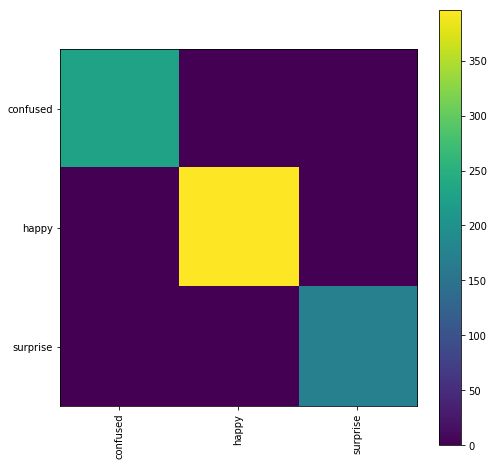

In [31]:
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
#Found 3150 images belonging to 3 classes.
#Found 797 images belonging to 3 classes.
nb_train_samples = 3150
nb_validation_samples = 797
batch_size=BATCH_SIZE_TESTING
# We need to recreate our validation generator with shuffle = false
validation_generator = data_generator.flow_from_directory(
        directory = '/notebooks/data3cls224_color_newimg_ORIGINAL/validation/',
        #color_mode = 'grayscale',
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TESTING,
        class_mode='categorical',
        shuffle=False,
        seed=123)

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, 797)
                                 #nb_validation_samples /batch_size)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

In [23]:
cnf_matrix

array([[228,   0,   0],
       [  0, 396,   0],
       [  0,   0, 173]])

In [24]:
cm=cnf_matrix
cm = cm.astype('float') / cm.sum(axis=1)[:,None]
cm

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

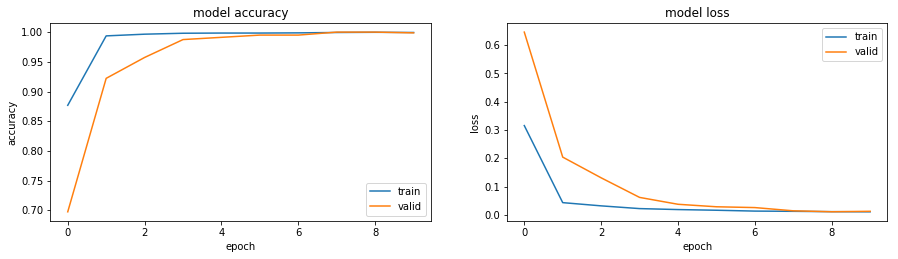

In [25]:
 plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['acc'])  
plt.plot(fit_history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

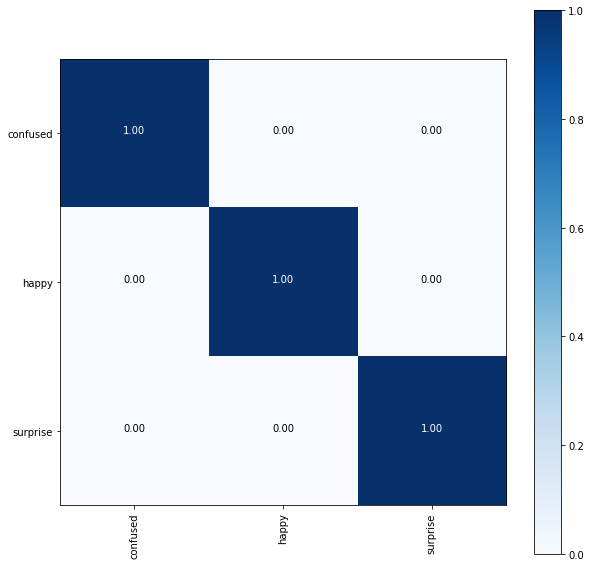

In [26]:
import itertools
cm=cnf_matrix
cm = cm.astype('float') / cm.sum(axis=1)[:,None]
plt.figure(figsize=(10,10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

fmt = '.2f'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")

# load model and check

In [27]:

# load and evaluate a saved model
from numpy import loadtxt
from tensorflow.keras.models import load_model

# load model
model = load_model('/notebooks/model_save/2clsmodel_highres.h5')
# summarize model.
model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


In [31]:
%time
from keras.preprocessing.image import load_img, img_to_array
base_path='/notebooks/data224x224_color/train/distracted/lm_dstr-122.jpg'
read_image = cv2.imread(base_path)
print(read_image.shape)
read_image = read_image.reshape(1,read_image.shape[0], read_image.shape[1], 3)
top_pred = model.predict(read_image)
print(top_pred)
#emotion_label = top_pred[0].argmax()
emotion_label = top_pred[0].argmax()
print(emotion_label)

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 13.4 µs
(224, 224, 3)
[[0.3512877  0.64871234]]
1
